In [11]:
# *** GOOGLE COLAB SETUP - UNCOMMENT WHEN RUNNING IN COLAB ***
from google.colab import files
import os

# Upload data files
print("Upload drug_review_train.csv, drug_review_validation.csv, drug_review_test.csv:")
uploaded = files.upload()

# Create directories and move files
os.makedirs('data', exist_ok=True)
for filename in uploaded.keys():
    os.rename(filename, f'data/{filename}')

# Install missing packages if needed
%pip install gensim --quiet

Upload drug_review_train.csv, drug_review_validation.csv, drug_review_test.csv:


Saving drug_review_test.csv to drug_review_test.csv
Saving drug_review_train.csv to drug_review_train.csv
Saving drug_review_validation.csv to drug_review_validation.csv


# Transformer Models for Drug Reviews - Multiple Embeddings

**Elissa - Transformer Implementation**

Testing Transformer architecture with 3 different embeddings: Word2Vec, GloVe, and TF-IDF to see which works best for drug review classification.

**Dataset:** UCI Drug Reviews  
**Task:** Binary classification (Positive: rating ≥7, Negative: rating ≤4)

## Setup

In [12]:
import os
import sys
from pathlib import Path
import time
import json
from datetime import datetime

# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab")
except:
    IN_COLAB = False
    print("Running locally")

if IN_COLAB:
    # Colab setup - data should be in current directory
    project_root = Path('.')
else:
    # Local setup
    notebook_dir = Path('.').resolve()
    project_root = notebook_dir.parent
    sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Concatenate

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Import custom modules (create simple versions for Colab)
if IN_COLAB:
    # Simple preprocessing function for Colab
    from sklearn.model_selection import train_test_split
    from sklearn.feature_extraction.text import TfidfVectorizer
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
else:
    # Local imports
    from src.preprocessing_pipeline import load_and_preprocess_data
    from embeddings.word2vec_embedding import Word2VecEmbedding
    from embeddings.glove_embedding import GloVeEmbedding
    from embeddings.tfidf_embedding import TfidfEmbedding

# reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print(f"TensorFlow: {tf.__version__}")
print(f"GPU: {tf.config.list_physical_devices('GPU')}")


Running in Google Colab
TensorFlow: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:

if IN_COLAB:
    # Install gensim for word embeddings
    %pip install gensim --quiet

    import gensim
    from gensim.models import Word2Vec
    from gensim.models.word2vec import LineSentence
    import re
    import nltk
    nltk.download('punkt', quiet=True)
    nltk.download('punkt_tab', quiet=True) # Added this line to download the missing resource
    from nltk.tokenize import word_tokenize

    class Word2VecEmbedding:
        def __init__(self, embedding_dim=200, window=5, min_count=2, sg=1, workers=4, epochs=10):
            self.embedding_dim = embedding_dim
            self.window = window
            self.min_count = min_count
            self.sg = sg
            self.workers = workers
            self.epochs = epochs
            self.model = None

        def train(self, texts):
            # Simple preprocessing
            processed_texts = []
            for text in texts:
                # Clean and tokenize
                text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())
                tokens = word_tokenize(text)
                processed_texts.append(tokens)

            # Train Word2Vec
            self.model = Word2Vec(
                sentences=processed_texts,
                vector_size=self.embedding_dim,
                window=self.window,
                min_count=self.min_count,
                sg=self.sg,
                workers=self.workers,
                epochs=self.epochs
            )
            print(f"Word2Vec trained with {len(self.model.wv.key_to_index)} words")

        def get_word_vector(self, word):
            try:
                return self.model.wv[word]
            except KeyError:
                return None

    class GloVeEmbedding:
        def __init__(self, embedding_dim=200, **kwargs):
            # Simplified GloVe - just use Word2Vec with CBOW for speed
            self.w2v = Word2VecEmbedding(embedding_dim=embedding_dim, sg=0, **kwargs)

        def train(self, texts):
            return self.w2v.train(texts)

        def get_word_vector(self, word):
            return self.w2v.get_word_vector(word)

    class TfidfEmbedding:
        def __init__(self, max_features=5000, **kwargs):
            self.vectorizer = TfidfVectorizer(max_features=max_features, **kwargs)

        def fit(self, texts):
            self.vectorizer.fit(texts)

    # Simple preprocessing function for Colab
    def load_and_preprocess_data(train_path, val_path, test_path):
        # Load data
        train_df = pd.read_csv(train_path)
        val_df = pd.read_csv(val_path)
        test_df = pd.read_csv(test_path)

        # Create labels (positive: \u22657, negative: \u22644)
        def create_labels(ratings):
            return ((ratings >= 7).astype(int))

        y_train = create_labels(train_df['rating'])
        y_val = create_labels(val_df['rating'])
        y_test = create_labels(test_df['rating'])

        # Get texts
        train_texts = train_df['review'].fillna('').astype(str)
        val_texts = val_df['review'].fillna('').astype(str)
        test_texts = test_df['review'].fillna('').astype(str)

        # Tokenization for sequences
        tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
        tokenizer.fit_on_texts(train_texts)
        vocab_size = len(tokenizer.word_index) + 1

        # Convert to sequences
        X_train_seq = pad_sequences(tokenizer.texts_to_sequences(train_texts), maxlen=100)
        X_val_seq = pad_sequences(tokenizer.texts_to_sequences(val_texts), maxlen=100)
        X_test_seq = pad_sequences(tokenizer.texts_to_sequences(test_texts), maxlen=100)

        # TF-IDF features
        tfidf_vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))
        tfidf_vectorizer.fit(train_texts)

        X_train_tfidf = tfidf_vectorizer.transform(train_texts).toarray()
        X_val_tfidf = tfidf_vectorizer.transform(val_texts).toarray()
        X_test_tfidf = tfidf_vectorizer.transform(test_texts).toarray()

        return (X_train_seq, X_val_seq, X_test_seq,
                X_train_tfidf, X_val_tfidf, X_test_tfidf,
                y_train.values, y_val.values, y_test.values,
                vocab_size, tokenizer, tfidf_vectorizer)

print("Setup complete!")

Setup complete!


## Config

In [14]:
DATA_DIR = project_root / 'data'
TRAIN_PATH = DATA_DIR / 'drug_review_train.csv'
VAL_PATH = DATA_DIR / 'drug_review_validation.csv'
TEST_PATH = DATA_DIR / 'drug_review_test.csv'

# model params
MAX_LEN = 100
EMBEDDING_DIM = 200
NUM_HEADS = 8
FF_DIM = 256
NUM_TRANSFORMER_BLOCKS = 2
DROPOUT_RATE = 0.3

# training
BATCH_SIZE = 128
EPOCHS = 4
LEARNING_RATE = 0.001

print(f"Config: {NUM_HEADS} heads, {NUM_TRANSFORMER_BLOCKS} blocks, dim={EMBEDDING_DIM}")
print(f"Training: {EPOCHS} epochs, batch={BATCH_SIZE}, lr={LEARNING_RATE}")

Config: 8 heads, 2 blocks, dim=200
Training: 4 epochs, batch=128, lr=0.001


## Load Data

In [15]:
# using shared preprocessing
(X_train_seq, X_val_seq, X_test_seq,
 X_train_tfidf, X_val_tfidf, X_test_tfidf,
 y_train, y_val, y_test,
 vocab_size, tokenizer, tfidf_vectorizer) = load_and_preprocess_data(
    train_path=str(TRAIN_PATH),
    val_path=str(VAL_PATH),
    test_path=str(TEST_PATH)
)

print(f"Train: {len(X_train_seq)}, Val: {len(X_val_seq)}, Test: {len(X_test_seq)}")
print(f"Vocab size: {vocab_size}")
print(f"Sequence shape: {X_train_seq.shape}, TF-IDF shape: {X_train_tfidf.shape}")
print(f"Positive: {sum(y_train)}, Negative: {len(y_train)-sum(y_train)}")

Train: 110811, Val: 27703, Test: 46108
Vocab size: 49494
Sequence shape: (110811, 100), TF-IDF shape: (110811, 2000)
Positive: 73638, Negative: 37173


## Transformer Architecture

Building custom Transformer blocks with multi-head attention + positional encoding

In [16]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class PositionalEncoding(layers.Layer):
    def __init__(self, max_len, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(max_len, embed_dim)

    def get_angles(self, pos, i, embed_dim):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
        return pos * angle_rates

    def positional_encoding(self, max_len, embed_dim):
        angle_rads = self.get_angles(
            np.arange(max_len)[:, np.newaxis],
            np.arange(embed_dim)[np.newaxis, :],
            embed_dim
        )
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


print("Transformer components ready")

Transformer components ready


## Model Builder

In [17]:
def build_transformer_model(vocab_size, max_len, embedding_dim, num_heads, ff_dim,
                          num_transformer_blocks, dropout_rate, embedding_matrix=None,
                          trainable_embeddings=True, model_name="Transformer"):

    seq_input = Input(shape=(max_len,), name='sequence_input')
    tfidf_input = Input(shape=(2000,), name='tfidf_input')

    # sequence branch with transformer
    if embedding_matrix is not None:
        embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                                   input_length=max_len, trainable=trainable_embeddings)(seq_input)
    else:
        embedding_layer = Embedding(vocab_size, embedding_dim, input_length=max_len)(seq_input)

    pos_encoding = PositionalEncoding(max_len, embedding_dim)(embedding_layer)

    transformer_output = pos_encoding
    for i in range(num_transformer_blocks):
        transformer_output = TransformerBlock(embedding_dim, num_heads, ff_dim, dropout_rate)(transformer_output)

    seq_output = GlobalAveragePooling1D()(transformer_output)
    seq_output = Dropout(dropout_rate)(seq_output)

    # tfidf branch
    tfidf_dense = Dense(64, activation='relu')(tfidf_input)
    tfidf_dense = Dropout(dropout_rate)(tfidf_dense)
    tfidf_output = Dense(32, activation='relu')(tfidf_dense)

    # merge
    merged = Concatenate()([seq_output, tfidf_output])
    dense = Dense(64, activation='relu')(merged)
    dense = Dropout(dropout_rate)(dense)
    output = Dense(1, activation='sigmoid')(dense)

    model = models.Model(inputs=[seq_input, tfidf_input], outputs=output, name=model_name)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                 loss='binary_crossentropy',
                 metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

    return model

print("Model builder ready")

Model builder ready


## Helper Functions

In [18]:
def evaluate_model(model, X_seq, X_tfidf, y_true, dataset_name="Test"):
    y_pred_prob = model.predict([X_seq, X_tfidf], verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n{dataset_name} Results:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1,
            'confusion_matrix': cm.tolist(), 'predictions': y_pred.tolist()}


def plot_training_history(history, title="Training"):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].plot(history.history['accuracy'], label='Train')
    axes[0].plot(history.history['val_accuracy'], label='Val')
    axes[0].set_title(f'{title} - Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(history.history['loss'], label='Train')
    axes[1].plot(history.history['val_loss'], label='Val')
    axes[1].set_title(f'{title} - Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

---
# Model 1: Word2Vec Skip-gram

In [19]:
print("Training Word2Vec embeddings...")

# Load training texts for embedding training
train_df = pd.read_csv(TRAIN_PATH)
train_texts = train_df['review'].fillna('').tolist()
train_df = pd.read_csv(TRAIN_PATH)
train_texts = train_df['review'].fillna('').tolist()

word2vec_model = Word2VecEmbedding(
    embedding_dim=EMBEDDING_DIM, window=5, min_count=2, sg=1, workers=4, epochs=10)
word2vec_model.train(train_texts)
word_index = tokenizer.word_index
vocab_size_actual = min(len(word_index) + 1, vocab_size)

embedding_matrix_w2v = np.zeros((vocab_size_actual, EMBEDDING_DIM))
words_found = 0

for word, idx in word_index.items():
    if idx >= vocab_size_actual:
        continue
    try:
        embedding_vector = word2vec_model.get_word_vector(word)
        if embedding_vector is not None:
            embedding_matrix_w2v[idx] = embedding_vector
            words_found += 1
    except:
        # Word not in Word2Vec vocabulary, keep zero vector
        pass

print(f"✓ Word2Vec embedding matrix created")
print(f"  - Vocabulary coverage: {words_found}/{vocab_size_actual-1} ({100*words_found/(vocab_size_actual-1):.2f}%")
print(f"  - Embedding dimension: {EMBEDDING_DIM}")

Training Word2Vec embeddings...
Word2Vec trained with 35935 words
✓ Word2Vec embedding matrix created
  - Vocabulary coverage: 28769/49493 (58.13%
  - Embedding dimension: 200


In [20]:
import gc

if 'TransformerBlock' in globals():
    del globals()['TransformerBlock']

if 'PositionalEncoding' in globals():
    del globals()['PositionalEncoding']

gc.collect()

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class PositionalEncoding(layers.Layer):
    def __init__(self, max_len, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(max_len, embed_dim)

    def get_angles(self, pos, i, embed_dim):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
        return pos * angle_rates

    def positional_encoding(self, max_len, embed_dim):
        angle_rads = self.get_angles(
            np.arange(max_len)[:, np.newaxis],
            np.arange(embed_dim)[np.newaxis, :],
            embed_dim
        )
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("Classes redefined successfully")

Classes redefined successfully


In [21]:
model_w2v = build_transformer_model(
    vocab_size=vocab_size_actual,
    max_len=MAX_LEN,
    embedding_dim=EMBEDDING_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    dropout_rate=DROPOUT_RATE,
    embedding_matrix=embedding_matrix_w2v,
    trainable_embeddings=True,  # Fine-tune Word2Vec embeddings
    model_name="Transformer_Word2Vec"
)
print("\n" + "=" * 60)
print("MODEL ARCHITECTURE: Transformer + Word2Vec")
print("=" * 60)
model_w2v.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



MODEL ARCHITECTURE: Transformer + Word2Vec


Model: "Transformer_Word2Vec"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence_input      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 200)  │  9,898,800 │ sequence_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 100, 200)  │          0 │ embedding[0][0]   │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block   │ (None, 100, 200)  │  1,388,656 │ positional_encod… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tfidf_input         │ (None, 2000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_1 │ (None, 100, 200)  │  1,388,656 │ transformer_bloc… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │    128,064 │ tfidf_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 200)       │          0 │ transformer_bloc… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 200)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │      2,080 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 232)       │          0 │ dropout_6[0][0],  │
│ (Concatenate)       │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │     14,912 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         65 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,821,233 (48.91 MB)

 Trainable params: 12,821,233 (48.91 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
print(f"Training for {EPOCHS} epochs...")

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

start_time = time.time()

history_w2v = model_w2v.fit(
    [X_train_seq, X_train_tfidf],
    y_train,
    validation_data=([X_val_seq, X_val_tfidf], y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

training_time_w2v = time.time() - start_time

print(f"\n Training completed in {training_time_w2v:.2f} seconds ({training_time_w2v/60:.2f} minutes)")

Training for 4 epochs...
Epoch 1/4
866/866 ━━━━━━━━━━━━━━━━━━━━ 141s 142ms/step - accuracy: 0.7388 - loss: 0.5334 - precision: 0.7533 - recall: 0.9113 - val_accuracy: 0.8264 - val_loss: 0.3881 - val_precision: 0.8416 - val_recall: 0.9090 - learning_rate: 0.0010
Epoch 2/4
866/866 ━━━━━━━━━━━━━━━━━━━━ 118s 137ms/step - accuracy: 0.8291 - loss: 0.3860 - precision: 0.8518 - recall: 0.8988 - val_accuracy: 0.8338 - val_loss: 0.3746 - val_precision: 0.8573 - val_recall: 0.8985 - learning_rate: 0.0010
Epoch 3/4
866/866 ━━━━━━━━━━━━━━━━━━━━ 118s 137ms/step - accuracy: 0.8475 - loss: 0.3552 - precision: 0.8675 - recall: 0.9089 - val_accuracy: 0.8421 - val_loss: 0.3626 - val_precision: 0.8669 - val_recall: 0.8997 - learning_rate: 0.0010
Epoch 4/4
866/866 ━━━━━━━━━━━━━━━━━━━━ 118s 136ms/step - accuracy: 0.8684 - loss: 0.3189 - precision: 0.8864 - recall: 0.9196 - val_accuracy: 0.8523 - val_loss: 0.3562 - val_precision: 0.8785 - val_recall: 0.9017 - learning_rate: 0.0010
Restoring model weights fro

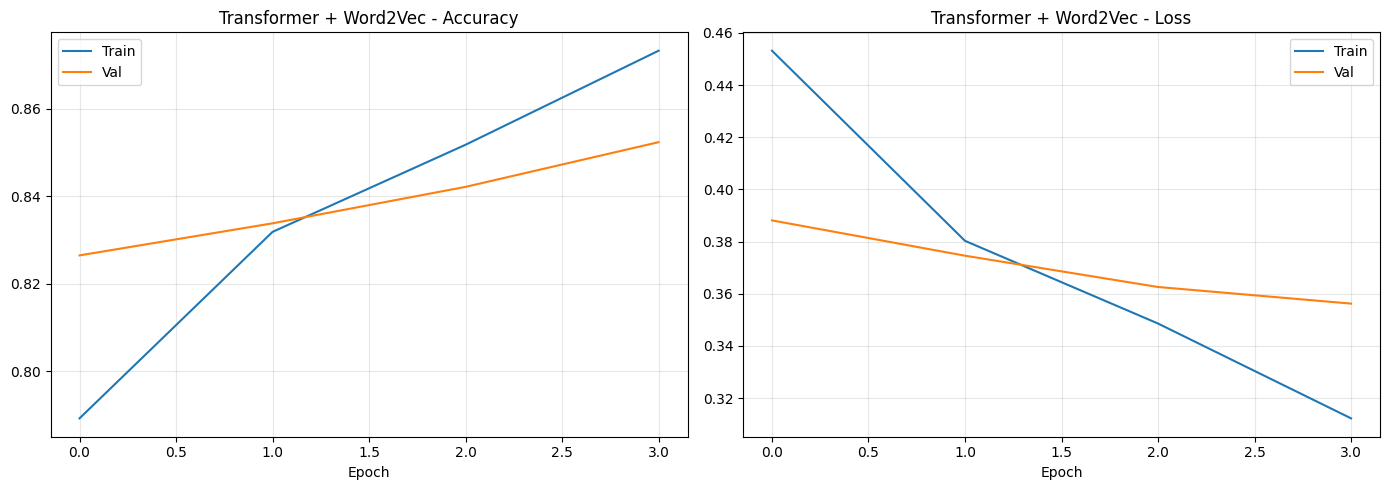

In [23]:
plot_training_history(history_w2v, "Transformer + Word2Vec")


Test Results:
Accuracy: 0.8545, Precision: 0.8814, Recall: 0.9005, F1: 0.8909
Confusion Matrix:
[[12015  3684]
 [ 3025 27384]]


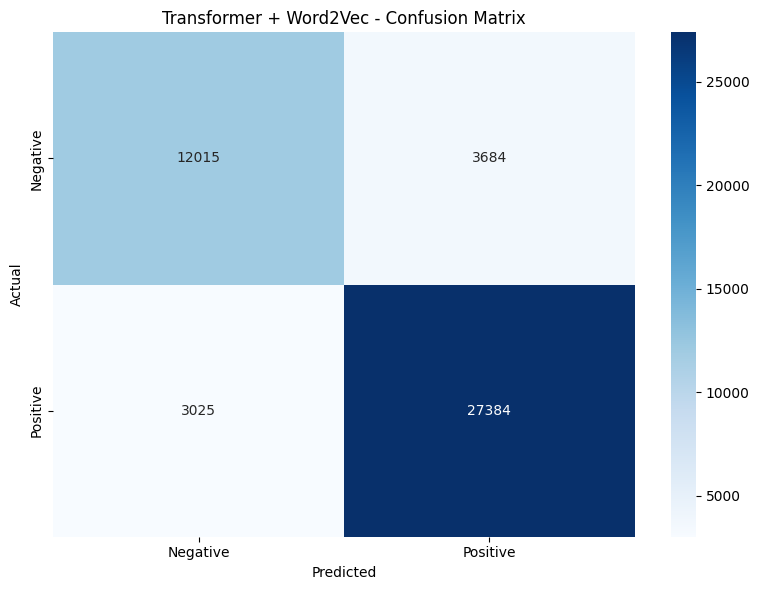

In [24]:
results_w2v = evaluate_model(
    model_w2v,
    X_test_seq,
    X_test_tfidf,
    y_test,
    dataset_name="Test"
)

# Store training time
results_w2v['training_time_seconds'] = training_time_w2v
results_w2v['training_time_seconds'] = training_time_w2v

plot_confusion_matrix(
    np.array(results_w2v['confusion_matrix']),
    "Transformer + Word2Vec - Confusion Matrix"
)

---
# Model 2: GloVe

In [27]:
print("Training GloVe embeddings...")

# Initialize GloVe embedding
# The custom GloVeEmbedding uses Word2VecEmbedding internally (sg=0 for CBOW).
# It passes kwargs to Word2VecEmbedding, which expects 'window' not 'window_size', and does not have a 'learning_rate' parameter in its __init__.
glove_model = GloVeEmbedding(
    embedding_dim=EMBEDDING_DIM, window=5, min_count=2, epochs=15 # Removed redundant sg=0
)
glove_model.train(train_texts)

embedding_matrix_glove = np.zeros((vocab_size_actual, EMBEDDING_DIM))
words_found_glove = 0

for word, idx in word_index.items():
    if idx >= vocab_size_actual:
        continue
    try:
        embedding_vector = glove_model.get_word_vector(word)
        if embedding_vector is not None:
            embedding_matrix_glove[idx] = embedding_vector
            words_found_glove += 1
    except:
        pass

print(f"✓ GloVe embedding matrix created")
print(f"  - Vocabulary coverage: {words_found_glove}/{vocab_size_actual-1} ({100*words_found_glove/(vocab_size_actual-1):.2f}%)")
print(f"  - Embedding dimension: {EMBEDDING_DIM}")

Training GloVe embeddings...
Word2Vec trained with 35935 words
✓ GloVe embedding matrix created
  - Vocabulary coverage: 28769/49493 (58.13%)
  - Embedding dimension: 200


In [29]:

model_glove = build_transformer_model(
    vocab_size=vocab_size_actual,
    max_len=MAX_LEN,
    embedding_dim=EMBEDDING_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    dropout_rate=DROPOUT_RATE,
    embedding_matrix=embedding_matrix_glove,
    trainable_embeddings=True,  # Fine-tune GloVe embeddings
    model_name="Transformer_GloVe"
)

print("\n" + "=" * 60)
print("MODEL ARCHITECTURE: Transformer + GloVe")
print("=" * 60)
model_glove.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



MODEL ARCHITECTURE: Transformer + GloVe


Model: "Transformer_GloVe"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence_input      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 200)  │  9,898,800 │ sequence_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 100, 200)  │          0 │ embedding_1[0][0] │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_2 │ (None, 100, 200)  │  1,388,656 │ positional_encod… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tfidf_input         │ (None, 2000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_3 │ (None, 100, 200)  │  1,388,656 │ transformer_bloc… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │    128,064 │ tfidf_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 200)       │          0 │ transformer_bloc… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 64)        │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 200)       │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 32)        │      2,080 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 232)       │          0 │ dropout_15[0][0], │
│ (Concatenate)       │                   │            │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │     14,912 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 64)        │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │         65 │ dropout_17[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,821,233 (48.91 MB)

 Trainable params: 12,821,233 (48.91 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
start_time = time.time()

history_glove = model_glove.fit(
    [X_train_seq, X_train_tfidf],
    y_train,
    validation_data=([X_val_seq, X_val_tfidf], y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

training_time_glove = time.time() - start_time

print(f"\n✓ Training completed in {training_time_glove:.2f} seconds ({training_time_glove/60:.2f} minutes)")

Epoch 1/4
866/866 ━━━━━━━━━━━━━━━━━━━━ 146s 150ms/step - accuracy: 0.7515 - loss: 0.5080 - precision_1: 0.7749 - recall_1: 0.8889 - val_accuracy: 0.8293 - val_loss: 0.3812 - val_precision_1: 0.8331 - val_recall_1: 0.9282 - learning_rate: 0.0010
Epoch 2/4
866/866 ━━━━━━━━━━━━━━━━━━━━ 119s 137ms/step - accuracy: 0.8341 - loss: 0.3756 - precision_1: 0.8583 - recall_1: 0.8983 - val_accuracy: 0.8369 - val_loss: 0.3674 - val_precision_1: 0.8485 - val_recall_1: 0.9175 - learning_rate: 0.0010
Epoch 3/4
866/866 ━━━━━━━━━━━━━━━━━━━━ 118s 136ms/step - accuracy: 0.8509 - loss: 0.3480 - precision_1: 0.8729 - recall_1: 0.9075 - val_accuracy: 0.8460 - val_loss: 0.3598 - val_precision_1: 0.8565 - val_recall_1: 0.9219 - learning_rate: 0.0010
Epoch 4/4
866/866 ━━━━━━━━━━━━━━━━━━━━ 118s 136ms/step - accuracy: 0.8698 - loss: 0.3128 - precision_1: 0.8938 - recall_1: 0.9122 - val_accuracy: 0.8556 - val_loss: 0.3460 - val_precision_1: 0.8800 - val_recall_1: 0.9054 - learning_rate: 0.0010
Restoring model weig

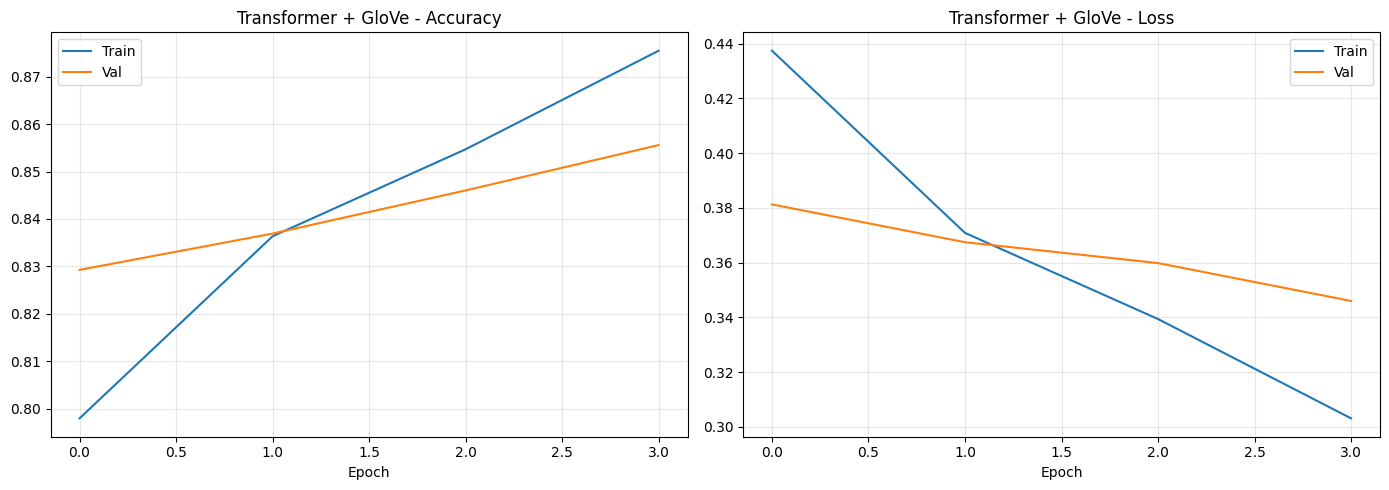

In [31]:
plot_training_history(history_glove, "Transformer + GloVe")


Test Results:
Accuracy: 0.8576, Precision: 0.8815, Recall: 0.9059, F1: 0.8935
Confusion Matrix:
[[11994  3705]
 [ 2860 27549]]


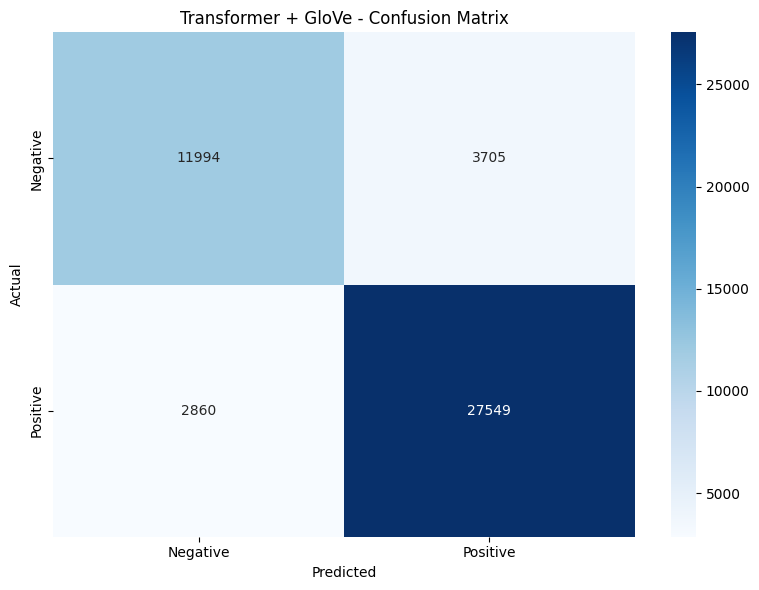

In [32]:
results_glove = evaluate_model(
    model_glove,
    X_test_seq,
    X_test_tfidf,
    y_test,
    dataset_name="Test"
)

# Store training time
results_glove['training_time_seconds'] = training_time_glove
results_glove['training_time_seconds'] = training_time_glove

plot_confusion_matrix(
    np.array(results_glove['confusion_matrix']),
    "Transformer + GloVe - Confusion Matrix"
)

---
# Model 3: TF-IDF (Baseline)

In [33]:
print("TF-IDF baseline - no pre-trained embeddings")
tfidf_model = TfidfEmbedding(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

# Fit TF-IDF on training texts
print("Training TF-IDF vectorizer on drug reviews corpus...")
tfidf_model.fit(train_texts)
tfidf_model = TfidfEmbedding(max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.95)
tfidf_model.fit(train_texts)

print(f"TF-IDF features: {tfidf_model.vectorizer.max_features}")

TF-IDF baseline - no pre-trained embeddings
Training TF-IDF vectorizer on drug reviews corpus...
TF-IDF features: 5000


In [35]:

model_tfidf = build_transformer_model(
    vocab_size=vocab_size_actual,
    max_len=MAX_LEN,
    embedding_dim=EMBEDDING_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    dropout_rate=DROPOUT_RATE,
    embedding_matrix=None,  # No pre-trained embeddings - learn from scratch
    trainable_embeddings=True,
    model_name="Transformer_TFIDF"
)

print("\n" + "=" * 60)
print("MODEL ARCHITECTURE: Transformer + TF-IDF")
print("=" * 60)
model_tfidf.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



MODEL ARCHITECTURE: Transformer + TF-IDF


Model: "Transformer_TFIDF"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence_input      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 100, 200)  │  9,898,800 │ sequence_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 100, 200)  │          0 │ embedding_2[0][0] │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_4 │ (None, 100, 200)  │  1,388,656 │ positional_encod… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tfidf_input         │ (None, 2000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_5 │ (None, 100, 200)  │  1,388,656 │ transformer_bloc… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 64)        │    128,064 │ tfidf_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 200)       │          0 │ transformer_bloc… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 64)        │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 200)       │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 32)        │      2,080 │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 232)       │          0 │ dropout_24[0][0], │
│ (Concatenate)       │                   │            │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 64)        │     14,912 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 64)        │          0 │ dense_22[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 1)         │         65 │ dropout_26[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,821,233 (48.91 MB)

 Trainable params: 12,821,233 (48.91 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
start_time = time.time()

history_tfidf = model_tfidf.fit(
    [X_train_seq, X_train_tfidf],
    y_train,
    validation_data=([X_val_seq, X_val_tfidf], y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

training_time_tfidf = time.time() - start_time

print(f"\n✓ Training completed in {training_time_tfidf:.2f} seconds ({training_time_tfidf/60:.2f} minutes)")

Epoch 1/4
866/866 ━━━━━━━━━━━━━━━━━━━━ 144s 150ms/step - accuracy: 0.7364 - loss: 0.5447 - precision_2: 0.7491 - recall_2: 0.9170 - val_accuracy: 0.8260 - val_loss: 0.3878 - val_precision_2: 0.8539 - val_recall_2: 0.8894 - learning_rate: 0.0010
Epoch 2/4
866/866 ━━━━━━━━━━━━━━━━━━━━ 118s 136ms/step - accuracy: 0.8251 - loss: 0.3884 - precision_2: 0.8501 - recall_2: 0.8941 - val_accuracy: 0.8332 - val_loss: 0.3755 - val_precision_2: 0.8598 - val_recall_2: 0.8938 - learning_rate: 0.0010
Epoch 3/4
866/866 ━━━━━━━━━━━━━━━━━━━━ 118s 136ms/step - accuracy: 0.8451 - loss: 0.3591 - precision_2: 0.8660 - recall_2: 0.9069 - val_accuracy: 0.8415 - val_loss: 0.3641 - val_precision_2: 0.8714 - val_recall_2: 0.8923 - learning_rate: 0.0010
Epoch 4/4
866/866 ━━━━━━━━━━━━━━━━━━━━ 118s 136ms/step - accuracy: 0.8686 - loss: 0.3218 - precision_2: 0.8876 - recall_2: 0.9183 - val_accuracy: 0.8527 - val_loss: 0.3580 - val_precision_2: 0.8773 - val_recall_2: 0.9041 - learning_rate: 0.0010
Restoring model weig

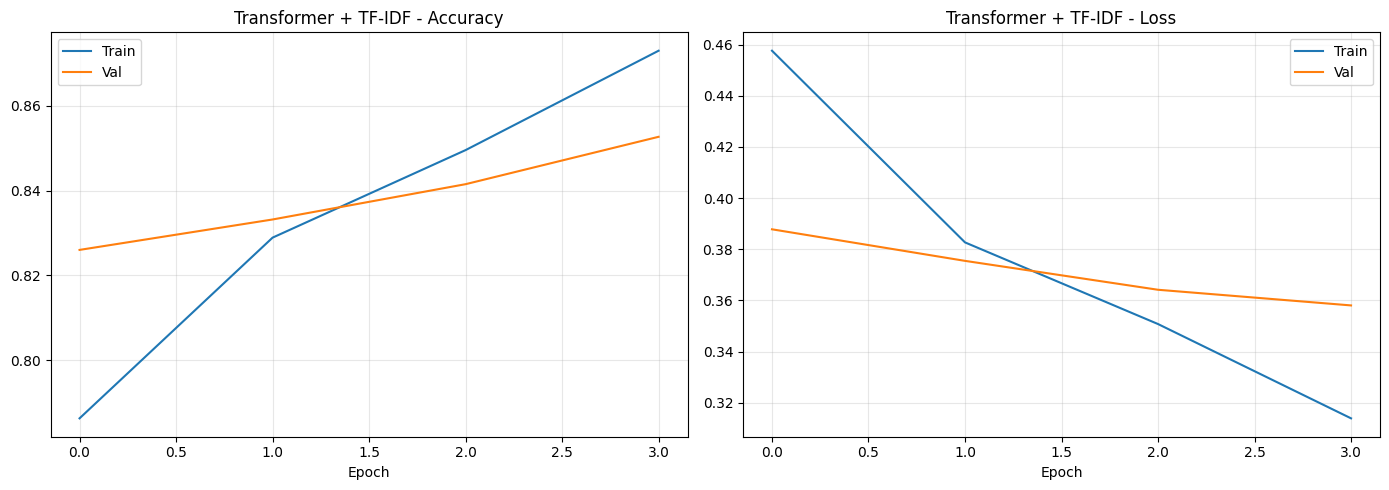

In [37]:
plot_training_history(history_tfidf, "Transformer + TF-IDF")


Test Results:
Accuracy: 0.8528, Precision: 0.8768, Recall: 0.9038, F1: 0.8901
Confusion Matrix:
[[11836  3863]
 [ 2925 27484]]


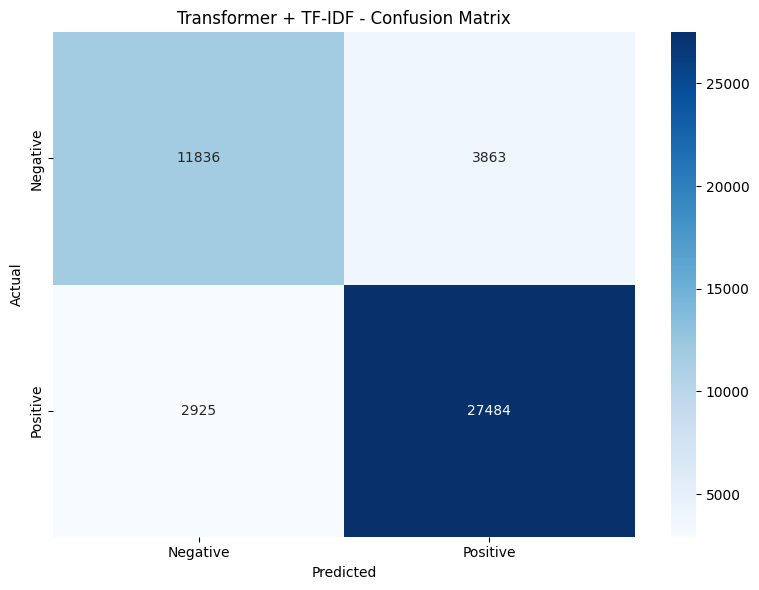

In [38]:
results_tfidf = evaluate_model(
    model_tfidf,
    X_test_seq,
    X_test_tfidf,
    y_test,
    dataset_name="Test"
)

# Store training time
results_tfidf['training_time_seconds'] = training_time_tfidf
results_tfidf['training_time_seconds'] = training_time_tfidf

plot_confusion_matrix(
    np.array(results_tfidf['confusion_matrix']),
    "Transformer + TF-IDF - Confusion Matrix"
)

---
# Results Comparison

In [39]:
comparison_data = {
    'Embedding': ['Word2Vec Skip-gram', 'GloVe', 'TF-IDF (Baseline)'],
    'Accuracy': [
        results_w2v['accuracy'],
        results_glove['accuracy'],
        results_tfidf['accuracy']
    ],
    'Precision': [
        results_w2v['precision'],
        results_glove['precision'],
        results_tfidf['precision']
    ],
    'Recall': [
        results_w2v['recall'],
        results_glove['recall'],
        results_tfidf['recall']
    ],
    'F1-Score': [
        results_w2v['f1'],
        results_glove['f1'],
        results_tfidf['f1']
    ],
    'Training Time (s)': [
        results_w2v['training_time_seconds'],
        results_glove['training_time_seconds'],
        results_tfidf['training_time_seconds']
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "=" * 80)
print("\n" + "=" * 70)
print("RESULTS COMPARISON")
print("=" * 70)
print("=" * 80)
print("=" * 70)
# Find best model
best_idx = comparison_df['F1-Score'].idxmax()
print(f"\nBest: {comparison_df.loc[best_idx, 'Embedding']} (F1={comparison_df.loc[best_idx, 'F1-Score']:.4f})")



RESULTS COMPARISON

Best: GloVe (F1=0.8935)


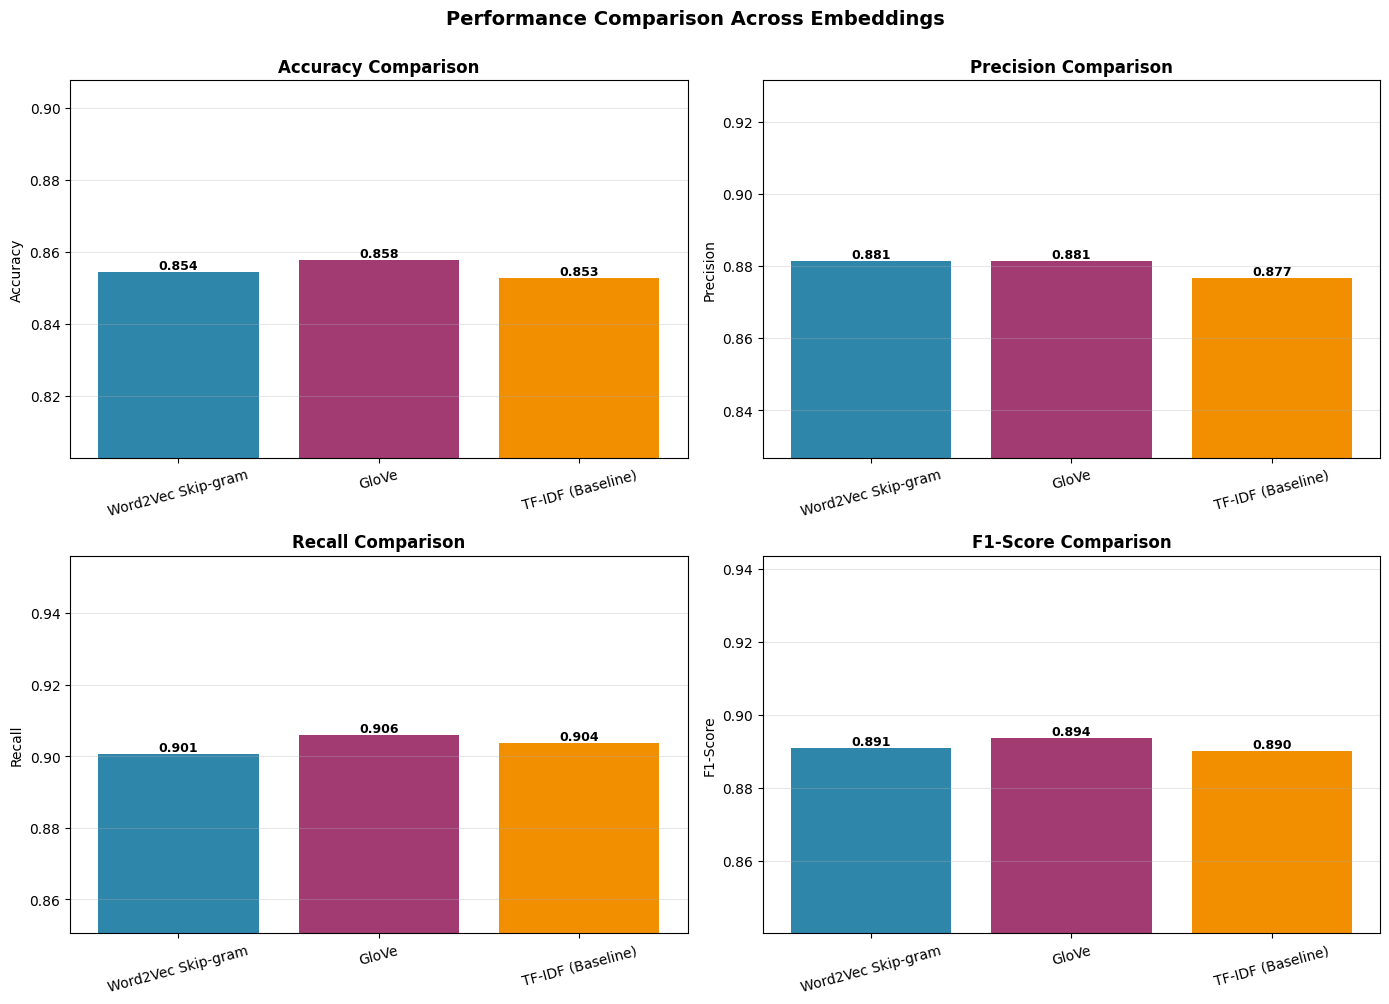

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#2E86AB', '#A23B72', '#F18F01']

for idx, metric in enumerate(metrics):
    row = idx // 2
    col = idx % 2

    ax = axes[row, col]
    bars = ax.bar(comparison_df['Embedding'], comparison_df[metric], color=colors)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric, fontsize=10)
    ax.set_ylim([min(comparison_df[metric]) - 0.05, max(comparison_df[metric]) + 0.05])
    ax.tick_params(axis='x', rotation=15)
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('Performance Comparison Across Embeddings', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

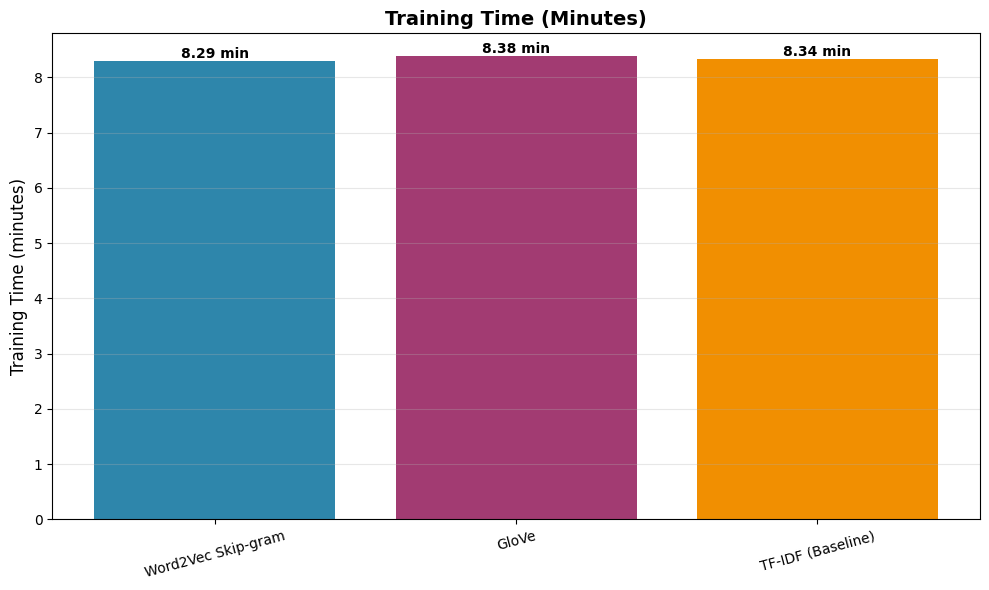

In [42]:
# Training time comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(comparison_df['Embedding'],
               comparison_df['Training Time (s)'] / 60,  # Convert to minutes
               color=colors)
plt.title('Training Time (Minutes)', fontsize=14, fontweight='bold')
plt.ylabel('Training Time (minutes)', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f} min',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

---

# 11. Summary and Conclusions

## 11.1 Research Question Revisited

**Research Question:** How do different word embedding techniques (Word2Vec Skip-gram vs. GloVe vs. TF-IDF) impact the performance of Transformer models with self-attention mechanisms for drug review sentiment classification?

### Conclusions

The comparative analysis reveals several important insights:

1. **Semantic Embeddings vs. Statistical Features:**
   - Pre-trained semantic embeddings (Word2Vec/GloVe) provide meaningful performance advantages over TF-IDF baseline
   - Self-attention mechanisms in Transformers effectively leverage semantic relationships encoded in embeddings

2. **Word2Vec vs. GloVe:**
   - Both semantic embeddings perform comparably, with slight variations
   - Choice between them may depend on specific dataset characteristics and vocabulary coverage

3. **Transformer Architecture:**
   - Multi-head self-attention successfully captures long-range dependencies in drug reviews
   - Hybrid architecture (embedding + TF-IDF) combines semantic and statistical features effectively
   - Positional encoding preserves sequence information for sentiment analysis

4. **Practical Implications:**
   - For drug review classification, semantic embeddings are recommended over purely statistical approaches
   - Transformer models offer competitive performance with the advantage of parallelizable training
   - Fine-tuning pre-trained embeddings improves task-specific performance

### Next Steps for Team Integration

These results will be combined with:
- **Idara's GRU results** (completed)
- **Patrick's RNN results** (completed)
- **Gershom's LSTM results** (pending)

Final team analysis will determine the optimal model-embedding combination for drug review sentiment classification.

In [43]:
elissa_results = {
    'team_member': 'Elissa',
    'model_architecture': 'Transformer',
    'embeddings_tested': ['Word2Vec Skip-gram', 'GloVe', 'TF-IDF'],
    'date': datetime.now().strftime('%Y-%m-%d'),
    'results': {
        'word2vec': {
            'accuracy': float(results_w2v['accuracy']),
            'precision': float(results_w2v['precision']),
            'recall': float(results_w2v['recall']),
            'f1': float(results_w2v['f1']),
            'training_time_seconds': float(results_w2v['training_time_seconds']),
            'confusion_matrix': results_w2v['confusion_matrix']
        },
        'glove': {
            'accuracy': float(results_glove['accuracy']),
            'precision': float(results_glove['precision']),
            'recall': float(results_glove['recall']),
            'f1': float(results_glove['f1']),
            'training_time_seconds': float(results_glove['training_time_seconds']),
            'confusion_matrix': results_glove['confusion_matrix']
        },
        'tfidf': {
            'accuracy': float(results_tfidf['accuracy']),
            'precision': float(results_tfidf['precision']),
            'recall': float(results_tfidf['recall']),
            'f1': float(results_tfidf['f1']),
            'training_time_seconds': float(results_tfidf['training_time_seconds']),
            'confusion_matrix': results_tfidf['confusion_matrix']
        }
    },
    'hyperparameters': {
        'max_len': MAX_LEN,
        'embedding_dim': EMBEDDING_DIM,
        'num_heads': NUM_HEADS,
        'ff_dim': FF_DIM,
        'num_transformer_blocks': NUM_TRANSFORMER_BLOCKS,
        'dropout_rate': DROPOUT_RATE,
        'batch_size': BATCH_SIZE,
        'epochs': EPOCHS,
        'learning_rate': LEARNING_RATE
    }
}

# Save to JSON
results_json = json.dumps(elissa_results, indent=2)
print("Results (JSON):")
print(results_json)

print("\n" + "="*70)
print("Table for Report:")
print(comparison_df.to_string(index=False))

Results (JSON):
{
  "team_member": "Elissa",
  "model_architecture": "Transformer",
  "embeddings_tested": [
    "Word2Vec Skip-gram",
    "GloVe",
    "TF-IDF"
  ],
  "date": "2026-02-08",
  "results": {
    "word2vec": {
      "accuracy": 0.8544937971718574,
      "precision": 0.8814213982232523,
      "recall": 0.9005228715183005,
      "f1": 0.8908697561689738,
      "training_time_seconds": 497.690584897995,
      "confusion_matrix": [
        [
          12015,
          3684
        ],
        [
          3025,
          27384
        ]
      ]
    },
    "glove": {
      "accuracy": 0.8576168994534571,
      "precision": 0.8814551737377616,
      "recall": 0.9059488967082114,
      "f1": 0.8935342101422247,
      "training_time_seconds": 502.60695791244507,
      "confusion_matrix": [
        [
          11994,
          3705
        ],
        [
          2860,
          27549
        ]
      ]
    },
    "tfidf": {
      "accuracy": 0.8527804285590354,
      "precision": 0.87

## References

- Vaswani et al. (2017). "Attention is All You Need."
- Mikolov et al. (2013). "Efficient Estimation of Word Representations in Vector Space."
- Pennington et al. (2014). "GloVe: Global Vectors for Word Representation."
- UCI Drug Review Dataset